 ### **Fuel Efficiency Prediction (TensorFlow)**

In [1]:
#Importing the neccesary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#For NumPy printouts easier to read
np.set_printoptions(precision=3, suppress = True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2023-04-28 14:34:22.518903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0


**The Auto MPG Dataset**
***
This dataset is available in UCI Machine Learning Repo.

In [3]:
#downloading and importing the dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
col_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration'
, 'Model Year', 'Origin']

raw_data = pd.read_csv(url, names=col_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_data.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


**Cleaning the data**

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

 - The 'Horsepower' seems to have a few null values.
  - Let's just take a mean value of the whole column and replace it.

In [6]:
dataset['Horsepower'].fillna(dataset['Horsepower'].mean(), inplace=True)

In [7]:
#lets check again if any null values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

 - __The 'Origin' column is categorical, <br> thus the next step would be to one-hot encode the values.__

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


**Splitting the dataset into training and test sets**.

In [10]:
#train, test, validation
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

  - The fuel efficiency (MPG) is a function of all other parameters.

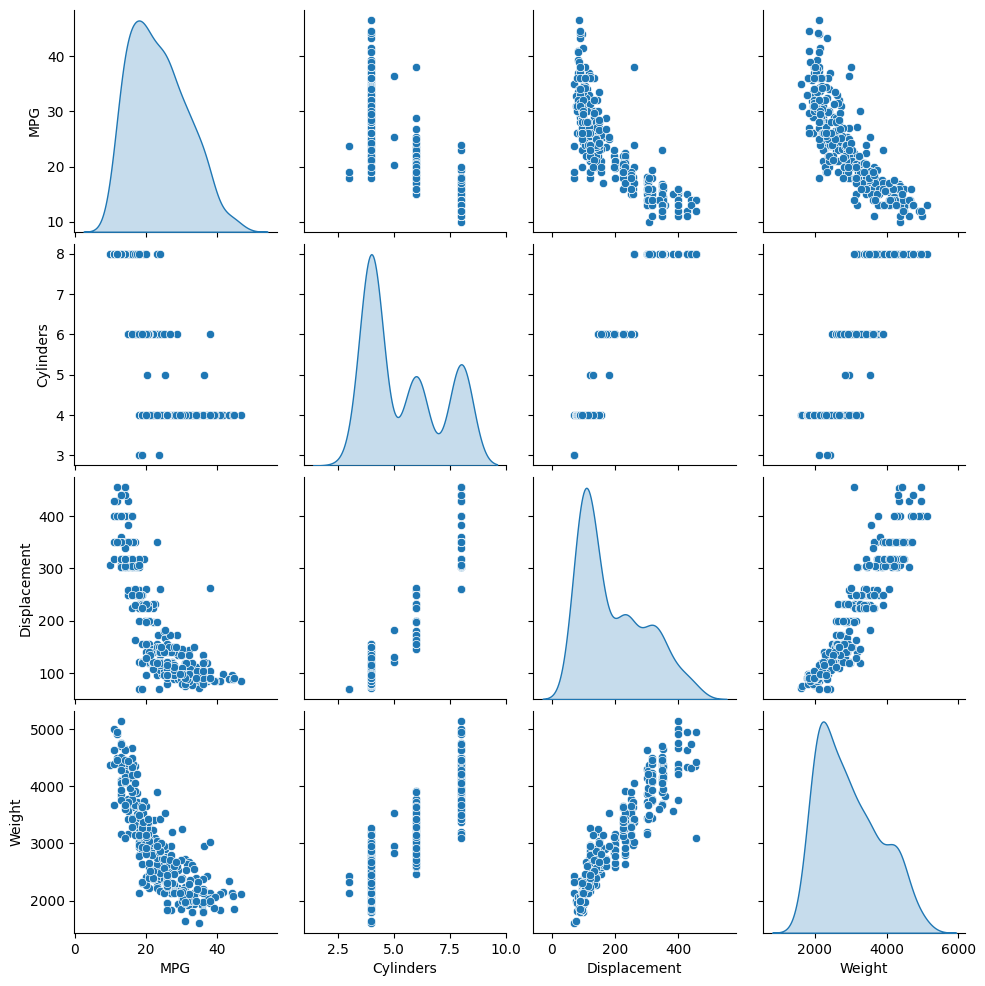

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,318.0,23.590566,7.913617,10.0,17.125,22.75,29.00,46.6
Cylinders,318.0,5.427673,1.682941,3.0,4.000,4.00,6.00,8.0
Displacement,318.0,193.061321,103.812742,70.0,100.250,151.00,259.50,455.0
Horsepower,318.0,104.073418,38.368477,46.0,75.250,92.00,120.00,230.0
Weight,318.0,2963.823899,844.749805,1613.0,2219.250,2792.50,3571.25,5140.0
Acceleration,318.0,15.595912,2.796282,8.0,13.900,15.50,17.30,24.8
Model Year,318.0,75.946541,3.705266,70.0,73.000,76.00,79.00,82.0
Europe,318.0,0.163522,0.370424,0.0,0.000,0.00,0.00,1.0
Japan,318.0,0.194969,0.396801,0.0,0.000,0.00,0.00,1.0
USA,318.0,0.641509,0.480313,0.0,0.000,1.00,1.00,1.0


__Note how each feature covers a different range.__

***
Split Features from 'label'
  - Seperating the target value from the features

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

__Normalization__

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.590566,7.913617
Cylinders,5.427673,1.682941
Displacement,193.061321,103.812742
Horsepower,104.073418,38.368477
Weight,2963.823899,844.749805
Acceleration,15.595912,2.796282
Model Year,75.946541,3.705266
Europe,0.163522,0.370424
Japan,0.194969,0.396801
USA,0.641509,0.480313


 - It is good practice to normalize features that use different scales and ranges.
***
 - One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
***
 - Although a model might converge without feature normalization, normalization makes training much more stable.

__The Normalization layer__

 - The "tf.keras.layers.Normalization" is a clean and simple way to add feature normalization into your model.

In [15]:
normalizer = tf.keras.layers.Normalization(axis=1)

 - Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:

In [16]:
normalizer.adapt(np.array(train_features))

In [17]:
print(normalizer.mean.numpy())

[[   5.428  193.061  104.073 2963.824   15.596   75.947    0.164    0.195
     0.642]]


In [18]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   8.  351.  153. 4129.   13.   72.    0.    0.    1.]]

Normalized: [[ 1.53  1.52  1.28  1.38 -0.93 -1.07 -0.44 -0.49  0.75]]


#### Linear Regression

 - Before building a deep neural network model, start with linear regression using one and several variables.



Begin with a single-variable linear regression to predict 'MPG' from 'Horsepower'.
***
Training a model with 'tf.keras' typically starts by defining the model architecture. <br>Use a 'tf.keras.Sequential' model, which represents a sequence of steps.

There are two steps in your single-variable linear regression model:

 - Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.<br>
 - Apply a linear transformation (y=mx + b) to produce 1 output using a linear layer (tf.keras.layers.Dense).

In [19]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [20]:
#now building a model
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict 'MPG' from 'Horsepower'

In [21]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 58ms/step


array([[ 1.336],
       [-0.794],
       [ 0.981],
       [-0.466],
       [-0.111],
       [-0.958],
       [-1.067],
       [-0.384],
       [ 1.254],
       [ 0.162]], dtype=float32)

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of (10, 1)

In [22]:
horsepower_model.compile(
    optimizer = tf.keras.optimizers.Adam(0.1),
    loss='mean_absolute_error'
)

In [23]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs = 100,
    verbose=0,
    validation_split=0.2
)

CPU times: user 2.76 s, sys: 196 ms, total: 2.95 s
Wall time: 2.67 s


In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.994690,3.961988,95
96,3.995636,3.951930,96
97,3.991180,3.954476,97
98,3.993212,3.963570,98
99,3.992160,3.957366,99


In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid()

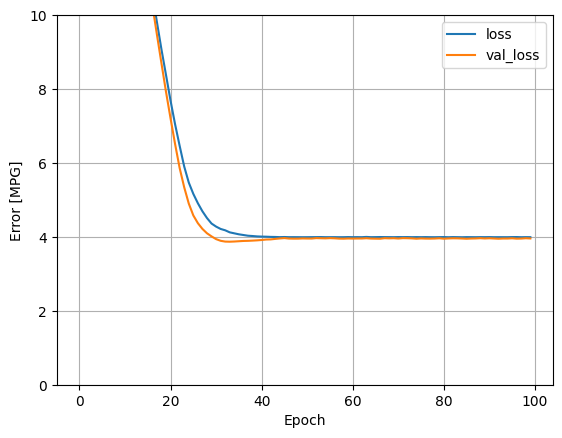

In [26]:
plot_loss(history)

In [27]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0
)

In [28]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 764us/step


In [29]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

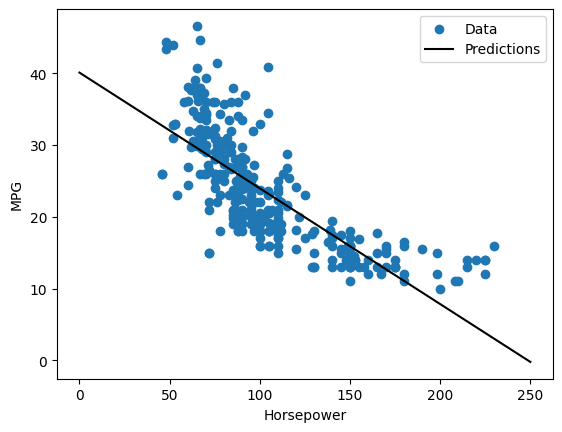

In [30]:
plot_horsepower(x,y)

 - Linear regression with multiple inputs.
 ***

In [31]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [32]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 38ms/step


array([[ 1.853],
       [ 0.178],
       [ 1.482],
       [ 0.798],
       [ 1.467],
       [-1.083],
       [-1.658],
       [-0.34 ],
       [ 2.801],
       [-0.601]], dtype=float32)

When you call the model, its weight matrices will be built—check that the kernel weights (the m in y = mx + b
) have a shape of (9, 1)

In [33]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.019],
       [ 0.079],
       [-0.589],
       [ 0.767],
       [-0.636],
       [-0.746],
       [-0.196],
       [-0.774],
       [-0.536]], dtype=float32)>

In [34]:
#Configuring the model
linear_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = 'mean_absolute_error'
)

In [35]:
%%time
histo = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2
)

CPU times: user 2.83 s, sys: 201 ms, total: 3.03 s
Wall time: 2.74 s


Using all the inputs in this regression model achieves a much lower training and validation error than the horsepower_model, which had one input

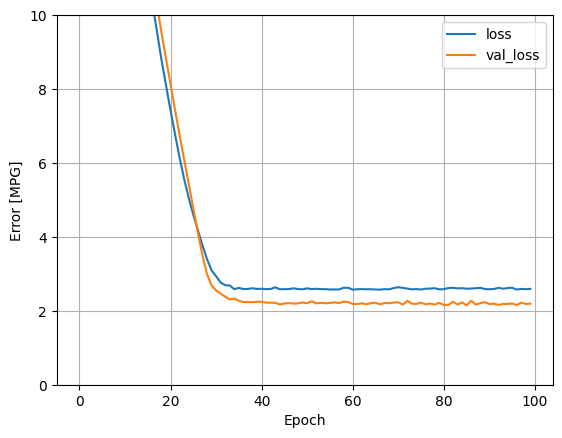

In [36]:
plot_loss(histo)

In [37]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

__Regression with a deep neural network (DNN)__

These models will contain a few more layers than the linear model:

 - The normalization layer, as before (with horsepower_normalizer for a single-input model and normalizer for a multiple-input model). <br>
 - Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.
 - A linear Dense single-output layer. <br>
Both models will use the same training procedure, so the compile method is included in the build_and_compile_model function below.

In [38]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

 - Regression using a DNN and a single input.
 ***
 Create a DNN model with only 'Horsepower' as input and horsepower_normalizer (defined earlier) as the normalization layer

In [39]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [40]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [41]:
%%time
model_history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100
)

CPU times: user 3.17 s, sys: 225 ms, total: 3.4 s
Wall time: 3 s


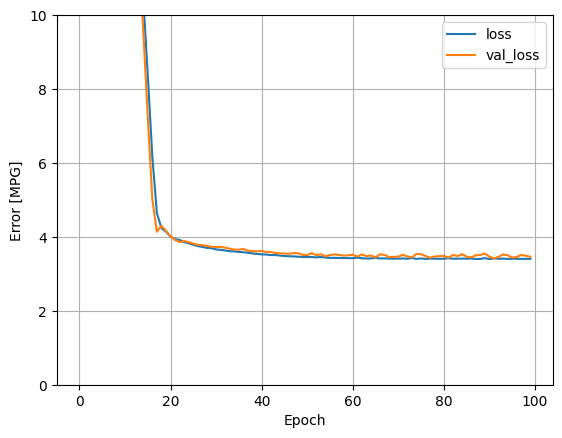

In [42]:
plot_loss(model_history)

If you plot the predictions as a function of 'Horsepower', you should notice how this model takes advantage of the nonlinearity provided by the hidden layers

In [43]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 801us/step


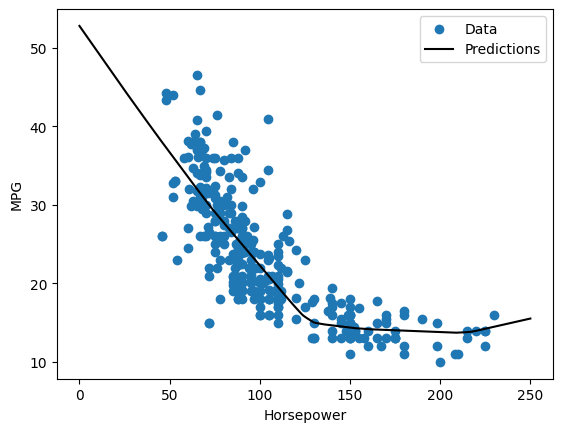

In [44]:
plot_horsepower(x, y)

In [45]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels, verbose=0
)

In [46]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [47]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100
)

CPU times: user 3.25 s, sys: 238 ms, total: 3.49 s
Wall time: 3.06 s


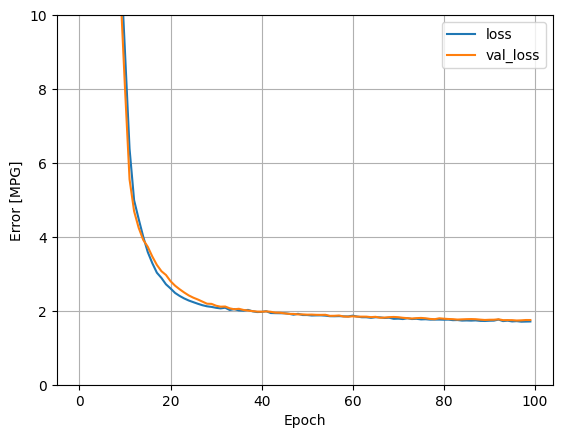

In [48]:
plot_loss(history)

In [49]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

__Performance__
***
Since all models have trained, you can review their test set performance.

In [50]:
pd.DataFrame(test_results, index=['Mean Absolute Error [MPG]']).T

,Mean Absolute Error [MPG]
horsepower_model,3.244652
linear_model,2.407460
dnn_horsepower_model,3.071749
dnn_model,1.875867


__Make Predictions__


3/3 [==============================] - 0s 1ms/step


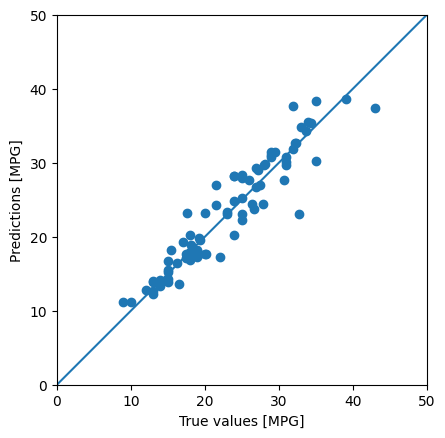

In [51]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [52]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


INFO:tensorflow:Assets written to: dnn_model/assets


In [53]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0
)

In [54]:
pd.DataFrame(test_results, index=['Mean Absolute Error [MPG]']).T

,Mean Absolute Error [MPG]
horsepower_model,3.244652
linear_model,2.407460
dnn_horsepower_model,3.071749
dnn_model,1.875867
reloaded,1.875867
